# Deutsch-Josza Algorithm
In this document, we shall describe the Deutsch-Josza Algorithm. The Deutsch-Josza Algorithm is a generalization of the Deutsch Algorithm to multiple qubits. We begin by importing the necessary components of qiskit. We also define the number of input qubits that we shall like to use.

In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
from qiskit.circuit import Gate
from qiskit.visualization import plot_histogram, plot_bloch_multivector

In [2]:
# Define no. of input qubits
n = 4

## Objective
We are given a function $f:\{0,1,2,...2^n-1\} \to \{0,1\}$ where $n$ is the no. of input bits. We are informed that this function belongs to one of two categories:

1. Constant function, i.e., either $f(x) = 0 \;\forall\; x$ or $f(x) = 1 \;\forall\; x$.
2. Balanced function, i.e., $f(x) = 0$ for half the inputs and $f(x) = 1$ for the other half of the inputs.

Note that a general function may not belong to either of these categories, but we are assured that our subroutine $f(x)$ is one of the above two. Our objective is to figure out which one; with minimum calls to the subroutine.

For a classical algorithm, if the function is constant, we would have to check the value of the $f(x)$ at half of the possible inputs at least to be sure. If the function is balanced, of course, we are likely to get the answer much earlier, i.e., as soon as we evaluate $f(x)$ at two inputs $x_1$ and $x_2$ such that $f(x_1) \neq f(x_2)$. In the worst case, $2^{n-1} + 1$ subroutine calls are required. The Deutsch-Josza Algorithm allows us to solve this problem with a single subroutine call on a quantum computer.

## Prerequisites
Before we describe the circuit for the Deutsch-Josza Algorithm, we shall need to develop a theorem that we will have the need to invoke, while describing the circuit operation. This is done in the following.

### Theorem 1
This theorem describes the action of a series of Hadamard Transforms on a series of qubits initialized to a general state $|x\rangle_n$. We claim that

$$H^{\otimes n}|x\rangle_n = \frac{1}{2^{n/2}} \sum_{y = 0}^{2^{n}-1} (-1)^{x \cdot y} |y\rangle_n$$

where
1. $H^{\otimes n}$ is the $H$ operator applied individually to each of the $n$ qubits.
2. $|x\rangle_n$ is a shorthand for the $n$ bit binary representation of $x$. For example, $|3\rangle_4 = |0011\rangle$
3. $x \cdot y = x_0y_0 \oplus x_1y_1 \oplus \cdots \oplus  x_{n-1}y_{n-1}$ (Bitwise AND, then XOR of all bits)

#### Proof
$$\begin{align*}
H^{\otimes n}|x\rangle_n &= H|x_0\rangle \otimes H|x_1\rangle \otimes \cdots \otimes H|x_{n-1}\rangle \\
&= \left(\frac{|0\rangle + (-1)^{x_0}|1\rangle}{\sqrt{2}}\right) \otimes \left(\frac{|0\rangle + (-1)^{x_1}|1\rangle}{\sqrt{2}}\right) \otimes \cdots \otimes \left(\frac{|0\rangle + (-1)^{x_{n-1}}|1\rangle}{\sqrt{2}}\right) \\
&= \frac{1}{2^{n/2}}\left(\left(|0\rangle + (-1)^{x_0}|1\rangle\right) \otimes \left(|0\rangle + (-1)^{x_1}|1\rangle\right) \otimes \cdots \otimes \left(|0\rangle + (-1)^{x_{n-1}}|1\rangle\right) \right)
\end{align*}$$

Now, consider how we would multiply out the $\left(|0\rangle + (-1)^{x_i}|1\rangle\right)$ terms. We would choose either a $|0\rangle$ or a $|1\rangle$ from each of these $n$ terms and multiply (or really tensor product) with the rest of the terms to get one term of the the total expansion. The $|1\rangle$ terms come with an extra coefficient of $(-1)^{x_i}$. The final multiplied out sum will thus be the sum of all $n$ bit combinations of zeroes and ones; where each term has a $\pm 1$ coefficient. These terms are essentially all possible instances of $|y\rangle_n$. Thus, the final sum will be of the form

$$H^{\otimes n}|x\rangle_n = \frac{1}{2^{n/2}} \sum_{y = 0}^{2^{n}-1} c_y |y\rangle_n$$

where each $c_y = \pm 1$. Now, we must calculate $c_y$ for a given $y$. For a fixed $y$, $c_y$ is a product of terms of the form $(-1)^{x_i}$. If the $i^{th}$ bit $y_i$, of $y$, is $0$, $(-1)^{x_i}$ would not be multiplied into $c_y$ (since $(-1)^{x_i}$ only comes in when we select a $1$ for the $i^{th}$ bit). It would be included however, if $y_i = 1$. We can account for both these cases by just multiplying $(-1)^{x_iy_i}$ into $c_y$. Therefore, considering all bits, we get,

$$c_y = (-1)^{x_0y_0}(-1)^{x_1y_1} \cdots (-1)^{x_{n-1}y_{n-1}} = (-1)^{x \cdot y}$$

Thus, we get our final result,

$$H^{\otimes n}|x\rangle_n = \frac{1}{2^{n/2}} \sum_{y = 0}^{2^{n}-1} (-1)^{x \cdot y} |y\rangle_n$$

#### Corollary
For the special case when the input qubits are all initialized to $|0\rangle$, we get,

$$H^{\otimes n}|0\rangle = \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} |x\rangle_n$$

## Circuit Description & Analysis
Now, we are finally in a position to describe the circuit for the Deutsch-Josza Algorithm.

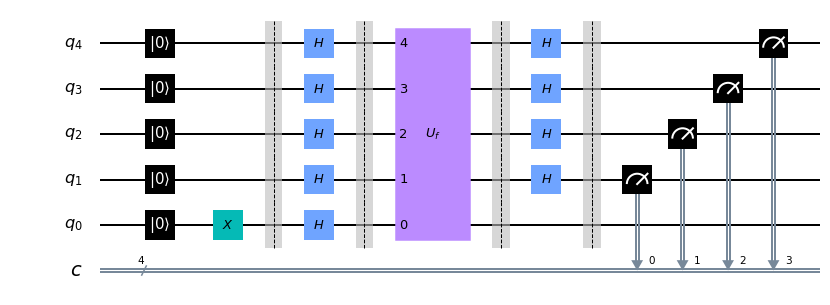

In [3]:
circ = QuantumCircuit(n+1, n)
circ.reset(range(n+1))
circ.x(0)
circ.barrier()
circ.h(range(n+1))
circ.barrier()
circ.append(Gate(name="$U_f$", num_qubits=n+1, params=[]), range(n+1))
circ.barrier()
circ.h(range(1, n+1))
circ.barrier()
circ.measure(range(1, n+1), range(n))
circ.draw('mpl', reverse_bits=True)

Here, the action of the $(n+1)$ qubit unitary operator $U_f$ is given by

$$U_f|xy\rangle = |x\rangle \otimes |y \oplus f(x)\rangle$$

where $x$ is an $n$ bit number and $y \in \{0,1\}$. In the above circuit, we have marked out 4 barriers. We shall describe the circuit operation by evaluating the quantum state of the qubits at these barriers, which we shall number 1-4 from left to right.

### Barrier 1
We initialize the $n$ qubit input register to zeros and the output qubit to 1. The state of the qubits is

$$|\psi_1\rangle = |0\rangle_n \otimes |1\rangle$$

### Barrier 2
We apply a chain of Hadamard Gates to the qubits. By the corollary to theorem 1 above, we get

$$\begin{align*}
|\psi_2\rangle &= H^{\otimes n}|0\rangle_n \otimes H|1\rangle \\
&= \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} |x\rangle_n \otimes \left(\frac{|0\rangle - |1\rangle}{\sqrt{2}}\right)
\end{align*}$$

### Barrier 3
We apply the Unitary gate $U_f$ to the qubits. We get

$$\begin{align*}
|\psi_3\rangle &= \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} |x\rangle_n \otimes \left(\frac{|0 \oplus f(x) \rangle - |1 \oplus f(x) \rangle}{\sqrt{2}}\right) \\
&= \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} (-1)^{f(x)}|x\rangle_n \otimes \left(\frac{|0\rangle - |1\rangle}{\sqrt{2}}\right) \\
&= \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} (-1)^{f(x)}|x\rangle_n \otimes H|1\rangle
\end{align*}$$

### Barrier 4
We apply a chain of Hadamard Gates to the $n$ qubit input register. From theorem 1 above, we get

$$\begin{align*}
|\psi_4\rangle &= \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} (-1)^{f(x)}H^{\otimes n}|x\rangle_n \otimes H|1\rangle \\
&= \frac{1}{2^n} \sum_{x = 0}^{2^{n}-1} \sum_{y = 0}^{2^{n}-1} (-1)^{f(x)} (-1)^{x \cdot y}|y\rangle_n \otimes H|1\rangle \\
&= \frac{1}{2^n} \sum_{x = 0}^{2^{n}-1} \sum_{y = 0}^{2^{n}-1} (-1)^{f(x) \oplus x \cdot y}|y\rangle_n \otimes H|1\rangle
\end{align*}$$

### Measurement
We shall then measure the $n$ qubit input register. The probability of getting all of these $n$ bits to be 0 is given by

$$\begin{align*}
P(0) &= \left|\frac{1}{2^n} \sum_{x = 0}^{2^{n}-1} \sum_{y = 0}^{2^{n}-1} (-1)^{f(x) \oplus x \cdot y}\langle0|y\rangle_n\right|^2 \\
&= \left|\frac{1}{2^n} \sum_{x = 0}^{2^{n}-1} (-1)^{f(x)}\right|^2
\end{align*}$$

In the above sum, in case of a constant $f(x)$, $2^n$ plus or minus ones add up to $\pm 2^n$. In case of a balanced function, equal number of plus and minus ones add up to $0$. Thus,

$$P(0) = \begin{cases}
1; \quad constant \\
0; \quad balanced
\end{cases}$$

Thus, on measurement of the input register, if we find a non zero output, we infer balanced category and if we get all zeros, we infer constant category. Notice that only one subroutine call was ever used.

## Qiskit Implementation
We shall need to construct the unitary operator $U_f$ before simulating our circuit. For the constant case, we shall simply choose $f(x) = 1$. For the balanced case, we choose $f(x) = x_0 \oplus x_1 \oplus \cdots x_{n-1}$. This function essentially tells us whether there are an even or odd number of ones in the binary expansion of the number $x$.

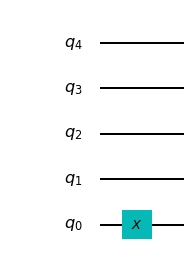

In [4]:
# Constant Function
constant = QuantumCircuit(n+1, name='Constant')
constant.x(0)
constant.draw('mpl', reverse_bits=True)

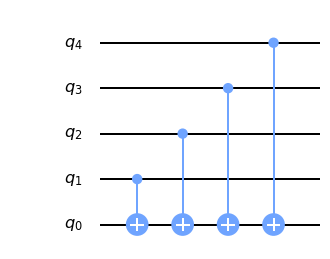

In [5]:
# Balanced Function
balanced = QuantumCircuit(n+1, name='Balanced')
for i in range(1, n+1):
    balanced.cx(i, 0)
balanced.draw('mpl', reverse_bits=True)

The action of the above circuits are easily verified to be consistent with the action of the unitary operator $U_f$ as

$$U_f|xy\rangle = |x\rangle \otimes |y \oplus f(x)\rangle$$

## State Vector Simulation
We shall first perform a state vector simulation of both cases.

### Constant Function
We expect the final state to be all zeros except for the qubit $q_0$, which is supposed to be in $H|1\rangle$. We plot the bloch multivector to show this.

In [6]:
circ = QuantumCircuit(n+1)
circ.x(0)
circ.barrier()
circ.h(range(n+1))
circ.append(constant.to_instruction(), range(n+1))
circ.h(range(1, n+1))
circ.draw(reverse_bits=True, plot_barriers=False)

┌───┐┌───────────┐┌───┐
q_4: ──────┤ H ├┤4          ├┤ H ├
           ├───┤│           │├───┤
q_3: ──────┤ H ├┤3          ├┤ H ├
           ├───┤│           │├───┤
q_2: ──────┤ H ├┤2 Constant ├┤ H ├
           ├───┤│           │├───┤
q_1: ──────┤ H ├┤1          ├┤ H ├
     ┌───┐ ├───┤│           │└───┘
q_0: ┤ X ├─┤ H ├┤0          ├─────
     └───┘ └───┘└───────────┘

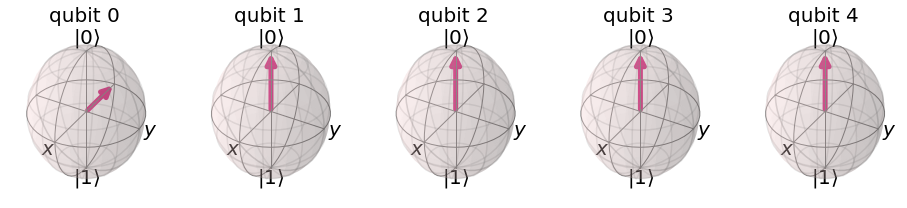

In [7]:
simulator = Aer.get_backend('statevector_simulator')
result = execute(circ, simulator).result()
state = result.get_statevector(circ)
plot_bloch_multivector(state)

### Balanced Function
For the balanced function, we expect the final state to have zero probability of getting all zeros on measurement. For this particular case, as the bloch multivector plot below shows, the state is all ones instead. Why is the state all ones? Refer to the Bernstein-Vazirani Algorithm for the answer.

In [8]:
circ = QuantumCircuit(n+1)
circ.x(0)
circ.barrier()
circ.h(range(n+1))
circ.append(balanced.to_instruction(), range(n+1))
circ.h(range(1, n+1))
circ.draw(reverse_bits=True, plot_barriers=False)

┌───┐┌───────────┐┌───┐
q_4: ──────┤ H ├┤4          ├┤ H ├
           ├───┤│           │├───┤
q_3: ──────┤ H ├┤3          ├┤ H ├
           ├───┤│           │├───┤
q_2: ──────┤ H ├┤2 Balanced ├┤ H ├
           ├───┤│           │├───┤
q_1: ──────┤ H ├┤1          ├┤ H ├
     ┌───┐ ├───┤│           │└───┘
q_0: ┤ X ├─┤ H ├┤0          ├─────
     └───┘ └───┘└───────────┘

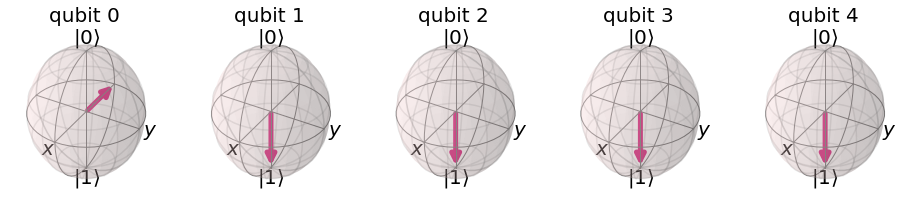

In [9]:
simulator = Aer.get_backend('statevector_simulator')
result = execute(circ, simulator).result()
state = result.get_statevector(circ)
plot_bloch_multivector(state)

## QASM Simulation
We shall simulate the case of the constant function in the QASM simulator for 1000 shots. This is done below. As expected, we obtain all zeros with a 100% probability

In [10]:
circ = QuantumCircuit(n+1, n)
circ.x(0)
circ.barrier()
circ.h(range(n+1))
circ.append(constant.to_instruction(), range(n+1))
circ.h(range(1, n+1))
circ.measure(range(1, n+1), range(n))
circ.draw(reverse_bits=True, plot_barriers=False)

┌───┐┌───────────┐┌───┐         ┌─┐
q_4: ──────┤ H ├┤4          ├┤ H ├─────────┤M├
           ├───┤│           │├───┤      ┌─┐└╥┘
q_3: ──────┤ H ├┤3          ├┤ H ├──────┤M├─╫─
           ├───┤│           │├───┤   ┌─┐└╥┘ ║ 
q_2: ──────┤ H ├┤2 Constant ├┤ H ├───┤M├─╫──╫─
           ├───┤│           │├───┤┌─┐└╥┘ ║  ║ 
q_1: ──────┤ H ├┤1          ├┤ H ├┤M├─╫──╫──╫─
     ┌───┐ ├───┤│           │└───┘└╥┘ ║  ║  ║ 
q_0: ┤ X ├─┤ H ├┤0          ├──────╫──╫──╫──╫─
     └───┘ └───┘└───────────┘      ║  ║  ║  ║ 
c_3: ══════════════════════════════╬══╬══╬══╩═
                                   ║  ║  ║    
c_2: ══════════════════════════════╬══╬══╩════
                                   ║  ║       
c_1: ══════════════════════════════╬══╩═══════
                                   ║          
c_0: ══════════════════════════════╩══════════

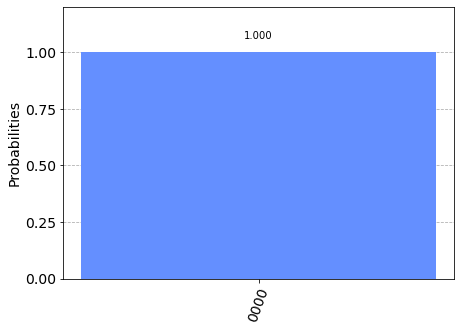

In [11]:
simulator = Aer.get_backend('qasm_simulator')
result = execute(circ, simulator, shots=1000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

## Remarks
The Deutsch-Josza Algorithm offers an exponential speedup over classical algorithms. However, the problem solved by the Deutsch-Josza Algorithm is still quite restricted. The Bernstein-Vazirani Algorithm uses the same circuit described above to solve a different problem. Although not too useful either, the Bernstein-Vazirani Algorithm is able to solve a problem with an $n$ bit numerical solution rather than a decision problem.

## References
1. Quantum theory, the Church–Turing principle and the universal quantum computer. (1985). Proceedings of the Royal Society of London. A. Mathematical and Physical Sciences, 400(1818), 97-117. https://doi.org/10.1098/rspa.1985.0070
2. Rapid solution of problems by quantum computation. (1992). Proceedings of the Royal Society of London. Series A: Mathematical and Physical Sciences, 439(1907), 553-558. https://doi.org/10.1098/rspa.1992.0167
3. Mermin, N. D. (2007). Quantum computer science: An introduction. Cambridge University Press.
4. Nielsen, M. A., & Chuang, I. L. (2010). Quantum computation and quantum information: 10th anniversary edition. Cambridge University Press.
5. Qiskit documentation — Qiskit 0.19.3 documentation. (n.d.). Qiskit. https://qiskit.org/documentation/